In [1]:
from clearml import Task

dataset = 'Adult_1'
task_filter={
    # filter out archived Tasks
    'system_tags': ['-archived'],
    # only completed & published Tasks
    'status': ['completed'],
    # only training type Tasks
    'type': ['training']
}
tags = [dataset]
task_list = Task.get_tasks(
    task_ids=None,  # type Optional[Sequence[str]]
    project_name="AI Fairness",  # Optional[str]
    task_name=None,  # Optional[str]
    task_filter=task_filter,  # Optional[Dict]
    tags=tags
)





In [2]:
len(task_list)

126

In [3]:
MAX_GRAD_NORMS = [0.01]
xavier_weight=True
model = "DP"
EPSILONS = [11.5, 3.2, 0.96, 0.72]
components = ['autoencoder', 'adversary', 'classifier', '']

In [4]:
import matplotlib.pyplot as plt
import numpy as np
best_epochs = {}
acc = {}
dp = {}
eod = {}
eop = {}
no_privacy = True
for MAX_GRAD_NORM_ in MAX_GRAD_NORMS:
    best_epoch_comp = {}
    acc_comp = {}
    dp_comp = {}
    eop_comp = {}
    eod_comp = {}
    for component in components:
        best_epoch_eps = {}
        acc_list = {}
        dp_list = {}
        eop_list = {}
        eod_list = {}
        for EPSILON_ in EPSILONS:
            MAX_GRAD_NORM = MAX_GRAD_NORM_
            EPSILON = EPSILON_
            l = [i.get_reported_scalars() for i in task_list if
                 'grad_norm='+str(MAX_GRAD_NORM) in i.data.tags and
                 component in i.data.tags and
                 "ε="+str(EPSILON) in i.data.tags and
                 "xavier_weight="+str(xavier_weight) in i.data.tags
                ]
            if len(component) == 0:
                if no_privacy:
                    l = [i.get_reported_scalars() for i in task_list if
                     'autoencoder' not in i.data.tags and
                     'adversary' not in i.data.tags and
                     'classifier' not in i.data.tags and
                     "xavier_weight="+str(xavier_weight) in i.data.tags
                    ]
                    MAX_GRAD_NORM = 0
                    EPSILON = 0
                    no_privacy = False
                else:
                    continue
            adv = [i['Adversary Loss']['test loss']['y'] for i in l]
            adv_mean = np.array(adv[0])
            
            cl = [i['Classifier Loss']['test loss']['y'] for i in l]
            cl_mean = np.array(cl[0])
            
            
            for i in range(1, len(adv)):
                adv_mean += np.array(adv[i])
                cl_mean += np.array(cl[i])
            adv_mean = np.array(adv_mean)
            cl_mean = np.array(cl_mean)
            adv_mean /= len(adv)
            cl_mean /= len(cl)
            

            w = int(len(adv_mean)*0.5)
            sm_y_adv = []
            sm_y_cl = []
            for i in range(len(adv_mean) - w):
                value = np.mean(adv_mean[i:i+w])
                sm_y_adv.append(value)
                value = np.mean(cl_mean[i:i+w])
                sm_y_cl.append(value)
            adv_epoch = np.argmax(sm_y_adv)
            cl_epoch = np.argmin(sm_y_cl)
            epoch_ = min(adv_epoch, cl_epoch)
            epoch_ = 180#max(epoch_, 50)
            print('MAX_GRAD_NORM:', MAX_GRAD_NORM, 'component:', component, 'eps:', EPSILON, 'best epoch:', epoch_)
            acc_, acc_unfair = [i['Accuracy'][model + ' test']['y'][epoch_] for i in l], [i['Accuracy']['Unfair test']['y'][epoch_] for i in l]
            dp_, dp_unfair = [i['ΔDP'][model + ' test']['y'][epoch_] for i in l], [i['ΔDP']['Unfair test']['y'][epoch_] for i in l] 
            eod_, eod_unfair = [i['ΔEOD'][model + ' test']['y'][epoch_] for i in l], [i['ΔEOD']['Unfair test']['y'][epoch_] for i in l] 
            eop_, eop_unfair = [i['ΔEOP'][model + ' test']['y'][epoch_] for i in l], [i['ΔEOP']['Unfair test']['y'][epoch_] for i in l]
            
            acc_list[EPSILON] = (np.mean(acc_), np.std(acc_, ddof=1), np.mean(acc_unfair))
            dp_list[EPSILON] = (np.mean(dp_), np.std(dp_, ddof=1), np.mean(dp_unfair))
            eod_list[EPSILON] = (np.mean(eod_), np.std(eod_, ddof=1), np.mean(eod_unfair))
            eop_list[EPSILON] = (np.mean(eop_), np.std(eop_, ddof=1), np.mean(eop_unfair))
            
            best_epoch_eps[EPSILON] = epoch_
            
        acc_comp[component] = acc_list
        dp_comp[component] = dp_list
        eod_comp[component] = eod_list
        eop_comp[component] = eop_list
        
        best_epoch_comp[component] = best_epoch_eps
        
    acc[MAX_GRAD_NORM] = acc_comp
    dp[MAX_GRAD_NORM] = dp_comp
    eop[MAX_GRAD_NORM] = eop_comp
    eod[MAX_GRAD_NORM] = eod_comp
    best_epochs[MAX_GRAD_NORM] = best_epoch_comp


MAX_GRAD_NORM: 0.01 component: autoencoder eps: 11.5 best epoch: 180
MAX_GRAD_NORM: 0.01 component: autoencoder eps: 3.2 best epoch: 180
MAX_GRAD_NORM: 0.01 component: autoencoder eps: 0.96 best epoch: 180
MAX_GRAD_NORM: 0.01 component: autoencoder eps: 0.72 best epoch: 180
MAX_GRAD_NORM: 0.01 component: adversary eps: 11.5 best epoch: 180
MAX_GRAD_NORM: 0.01 component: adversary eps: 3.2 best epoch: 180
MAX_GRAD_NORM: 0.01 component: adversary eps: 0.96 best epoch: 180
MAX_GRAD_NORM: 0.01 component: adversary eps: 0.72 best epoch: 180
MAX_GRAD_NORM: 0.01 component: classifier eps: 11.5 best epoch: 180
MAX_GRAD_NORM: 0.01 component: classifier eps: 3.2 best epoch: 180
MAX_GRAD_NORM: 0.01 component: classifier eps: 0.96 best epoch: 180
MAX_GRAD_NORM: 0.01 component: classifier eps: 0.72 best epoch: 180
MAX_GRAD_NORM: 0 component:  eps: 0 best epoch: 180


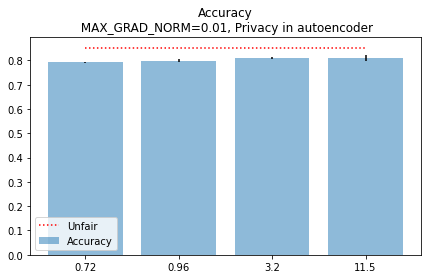

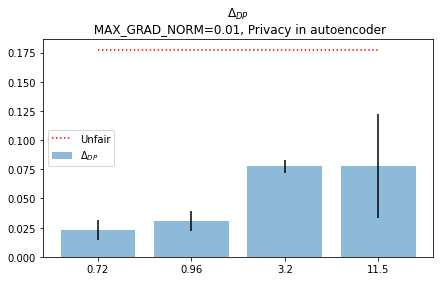

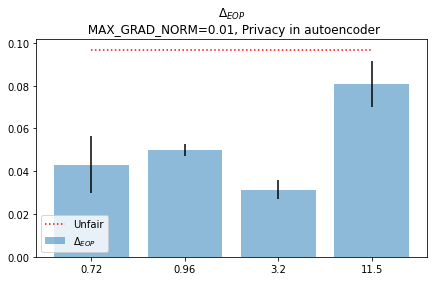

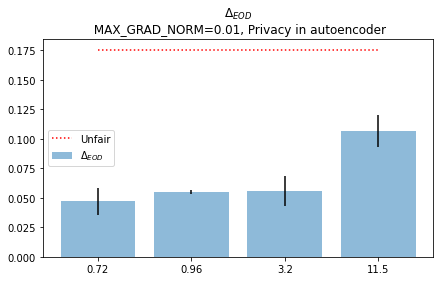

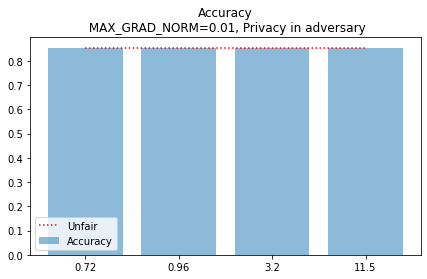

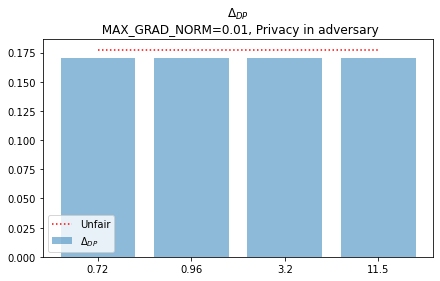

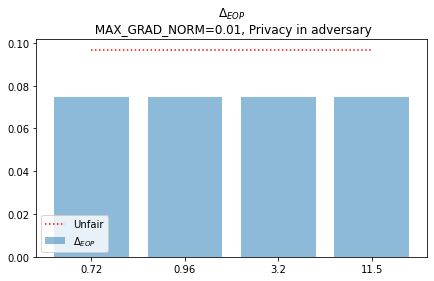

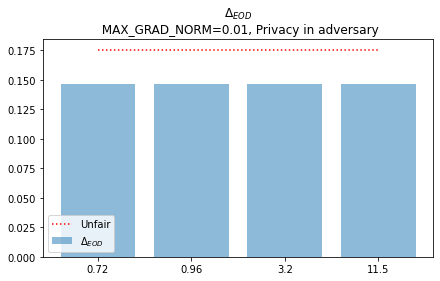

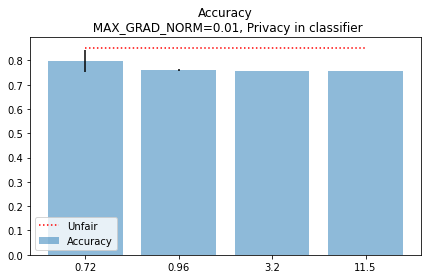

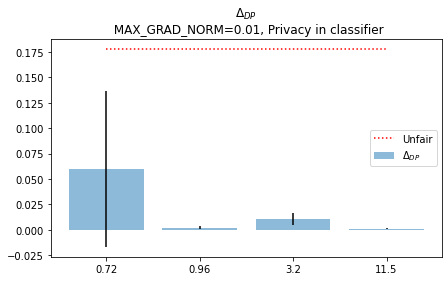

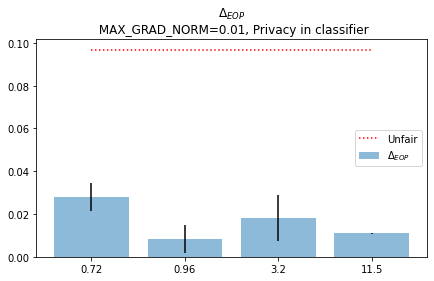

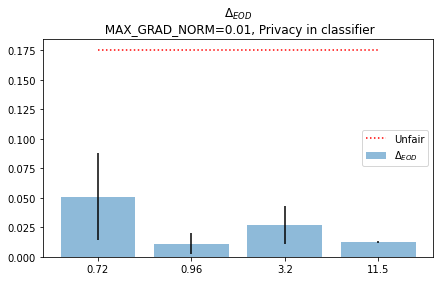

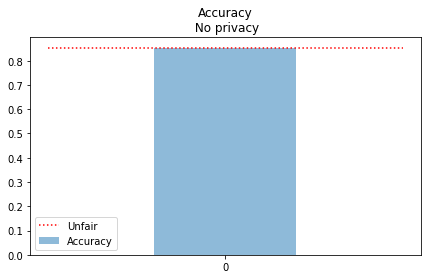

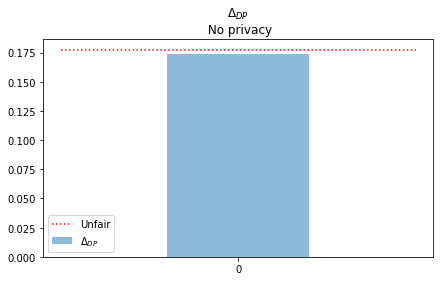

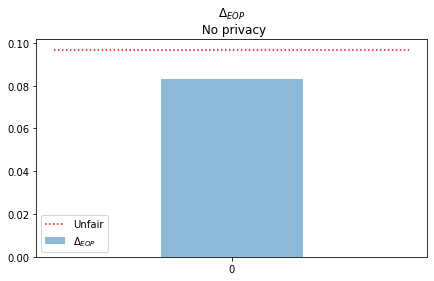

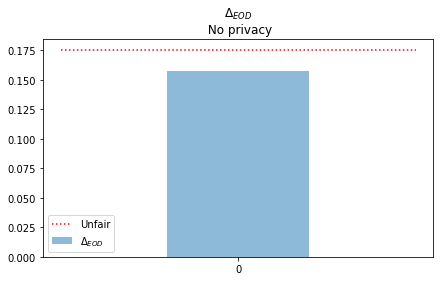

In [5]:
import matplotlib
%matplotlib inline
no_privacy = True
for MAX_GRAD_NORM_ in MAX_GRAD_NORMS:
    for component in components:
        MAX_GRAD_NORM = MAX_GRAD_NORM_
        EPSILONS_ = EPSILONS
        if len(component) == 0:
            if no_privacy:
                EPSILONS_ = [0]
                no_privacy = False
            else:
                continue
        labels = ["Accuracy", "$\Delta_{DP}$", '$\Delta_{EOP}$', '$\Delta_{EOD}$']
        y = [
            [acc[MAX_GRAD_NORM][component][EPSILON][0] for EPSILON in sorted(EPSILONS_)],
            [dp[MAX_GRAD_NORM][component][EPSILON][0] for EPSILON in sorted(EPSILONS_)],
            [eop[MAX_GRAD_NORM][component][EPSILON][0] for EPSILON in sorted(EPSILONS_)],
            [eod[MAX_GRAD_NORM][component][EPSILON][0] for EPSILON in sorted(EPSILONS_)]
        ]
        std = [
            [acc[MAX_GRAD_NORM][component][EPSILON][1] for EPSILON in sorted(EPSILONS_)],
            [dp[MAX_GRAD_NORM][component][EPSILON][1] for EPSILON in sorted(EPSILONS_)],
            [eop[MAX_GRAD_NORM][component][EPSILON][1] for EPSILON in sorted(EPSILONS_)],
            [eod[MAX_GRAD_NORM][component][EPSILON][1] for EPSILON in sorted(EPSILONS_)]
        ]
        unfair = [
            [acc[MAX_GRAD_NORM][component][EPSILON][2] for EPSILON in sorted(EPSILONS_)],
            [dp[MAX_GRAD_NORM][component][EPSILON][2] for EPSILON in sorted(EPSILONS_)],
            [eop[MAX_GRAD_NORM][component][EPSILON][2] for EPSILON in sorted(EPSILONS_)],
            [eod[MAX_GRAD_NORM][component][EPSILON][2] for EPSILON in sorted(EPSILONS_)]
        ]
        for p in range(len(y)):
            fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 4))
            ax.bar(np.arange(len(EPSILONS_)), y[p], yerr=std[p], label=labels[p], alpha=0.5)
            title = labels[p] + "\n MAX_GRAD_NORM=" + str(MAX_GRAD_NORM) + ", Privacy in " + component if len(EPSILONS_) > 1\
            else labels[p] + "\n No privacy"
            ax.set_xticks(np.arange(len(EPSILONS_)))
            ax.set_xticklabels([str(i) for i in sorted(EPSILONS_)])
            ax.set_title(title)
            ax.plot(np.arange(len(EPSILONS_)), unfair[p], label="Unfair", linestyle='dotted', color='red') if len(EPSILONS_) > 1\
            else ax.plot(np.arange(-1, len(EPSILONS_) + 1), [unfair[p], unfair[p], unfair[p]], label="Unfair", linestyle='dotted', color='red')
            ax.legend()
            plt.show()
            

            
            

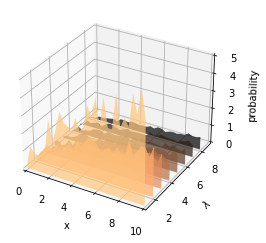

In [52]:
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
import numpy as np


# Fixing random state for reproducibility
np.random.seed(19680801)


def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x = np.linspace(0., 10., 31)
lambdas = range(1, 9)

# verts[i] is a list of (x, y) pairs defining polygon i.
verts = [polygon_under_graph(x, [(i**0.5+np.random.randint(-10, 10)/10)/l for i in range(len(x))]) for l in lambdas]


poly = PolyCollection(verts, facecolors=plt.get_cmap('copper')(np.linspace(1, 0, len(verts))),  alpha=.7)
ax.add_collection3d(poly, zs=lambdas, zdir='y')

ax.set(xlim=(min(x), max(x)), ylim=(1, 9), zlim=(0, 5),
       xlabel='x', ylabel=r'$\lambda$', zlabel='probability')

plt.show()

In [34]:
plt.get_cmap(name)['viridis_r'](np.linspace(0, 1, len(verts)))

TypeError: 'function' object is not subscriptable